In [ ]:
# GOALS FOR SATURDAY
# - present
# - update chart to include greenspace percentages based on mileage not count
# - make green space GREEN
# - update short term rental lineplot to include non active strs
# - composite over time analysis!
# - check with rob/jonathon about composite analysis

# COLOR SCHEME
# blue for crime
# green for green space
# yellow/orange for strs

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from pypalettes import load_cmap
from highlight_text import fig_text, ax_text
from pyfonts import load_font

In [6]:
arrests = pd.read_csv('../data/composite/precinct_arrests.csv')

In [7]:
greenspace = pd.read_csv('../data/composite/precinct_greenspace.csv')

In [8]:
permits = pd.read_csv('../data/composite/precinct_permits.csv')

In [ ]:
# Because the value ranges are so different between all three factors, I'll be taking the averages of each and calculating how much each precinct's factors vary from the average.

In [36]:
def percent_change(df, value_col='Value'):
    mean_val = df[value_col].mean()
    df['PercChange'] = ((df[value_col] - mean_val) / mean_val) * 100
    return df

### arrests

In [40]:
arrests = arrests.drop(columns='Unnamed: 0')

In [41]:
percent_change(arrests, value_col='objid')

,PRECINCT,objid,PercChange
0,CENTRAL,13152,-21.743981
1,EAST,16499,-1.828919
2,HERMITAGE,21611,28.588110
3,MADISON,15432,-8.177700
4,MIDTOWN,13102,-22.041487
5,NORTH,19585,16.533161
7,SOUTH,25295,50.508364
8,WEST,9775,-41.837547


In [51]:
arrests_pct = arrests.drop(columns='objid')

### greenspace

In [44]:
greenspace = greenspace.drop(columns='Unnamed: 0')

In [45]:
percent_change(greenspace, value_col='GlobalID')

,PRECINCT,GlobalID,PercChange
0,CENTRAL,15,-70.660147
1,EAST,41,-19.804401
2,HERMITAGE,48,-6.112469
3,MADISON,32,-37.408313
4,MIDTOWN,30,-41.320293
5,NORTH,53,3.667482
6,SOUTH,62,21.271394
7,WEST,128,150.366748


In [52]:
greenspace_pct = greenspace.drop(columns='GlobalID')

### permits

In [47]:
permits = permits.drop(columns='Unnamed: 0')

In [79]:
mask = (permits['PRECINCT'].isin(['MIDTOWN-HILLS']))
permits.loc[mask, 'PRECINCT'] = permits.loc[mask, 'PRECINCT'] = 'MIDTOWN'

In [80]:
percent_change(permits, value_col='Permit__')

,PRECINCT,Permit__,PercChange
0,CENTRAL,1556,65.027178
1,EAST,1536,62.906006
2,HERMITAGE,363,-61.500729
3,MADISON,151,-83.985152
4,MIDTOWN,1743,84.860135
5,NORTH,1360,44.239692
6,SOUTH,448,-52.485748
7,WEST,386,-59.061381


In [81]:
permits_pct = permits.drop(columns='Permit__')

### Joining

In [82]:
# Excluding 'Outside Nash'
arrests = arrests.loc[arrests['PRECINCT'].isin(['CENTRAL', 'EAST', 'HERMITAGE', 'MADISON', 'MIDTOWN', 'NORTH', 'SOUTH', 'WEST'])]

In [83]:
# Joining arrests and greenspace
arrests_grnspc = (pd.merge(left=arrests_pct, right=greenspace_pct, how='left', on='PRECINCT')
                    .rename(columns={'PercChange_x' : 'arrests_pct', 'PercChange_y' : 'grnspc_pct'})
                    )

In [84]:
# Joining permits
composite = (pd.merge(left=arrests_grnspc, right=permits_pct, how='left', on='PRECINCT')
                    .rename(columns={'PercChange' : 'permits_pct'})
                    )

In [85]:
composite

,PRECINCT,arrests_pct,grnspc_pct,permits_pct
0,CENTRAL,-21.743981,-70.660147,65.027178
1,EAST,-1.828919,-19.804401,62.906006
2,HERMITAGE,28.588110,-6.112469,-61.500729
3,MADISON,-8.177700,-37.408313,-83.985152
4,MIDTOWN,-22.041487,-41.320293,84.860135
5,NORTH,16.533161,3.667482,44.239692
6,SOUTH,50.508364,21.271394,-52.485748
7,WEST,-41.837547,150.366748,-59.061381


In [86]:
comp_melt = pd.melt(composite, id_vars='PRECINCT', value_vars=['arrests_pct', 'grnspc_pct', 'permits_pct'],
                    var_name='category', value_name='counts')

In [87]:
comp_melt

,PRECINCT,category,counts
0,CENTRAL,arrests_pct,-21.743981
1,EAST,arrests_pct,-1.828919
2,HERMITAGE,arrests_pct,28.588110
3,MADISON,arrests_pct,-8.177700
4,MIDTOWN,arrests_pct,-22.041487
5,NORTH,arrests_pct,16.533161
6,SOUTH,arrests_pct,50.508364
7,WEST,arrests_pct,-41.837547
8,CENTRAL,grnspc_pct,-70.660147
9,EAST,grnspc_pct,-19.804401


In [88]:
# Theme
colors = ["#032c3c", "#970808", '#f29544']
sns.set_palette(sns.color_palette(colors))

# Style
sns.set(rc={'axes.facecolor':'#eaeaea', 
            "axes.edgecolor" : '032c3c',
            "axes.labelcolor" : '032c3c',
            'figure.facecolor':'#eaeaea',
            'grid.color' : "#032c3c"})

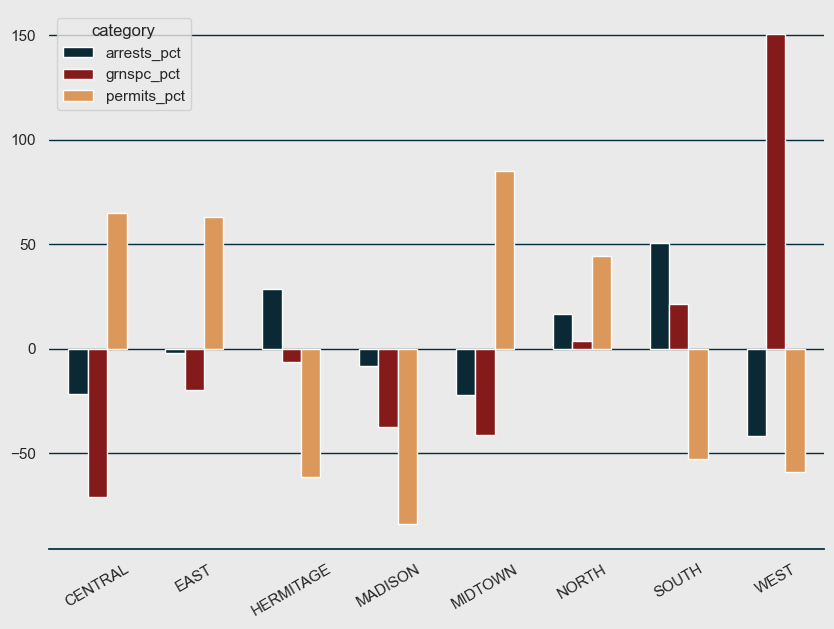

In [89]:
plt.figure(figsize=(10, 7))
sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(
    x="PRECINCT", 
    y="counts", 
    data=comp_melt,
    hue = 'category',
    width=0.6
)
ax.set_xlabel("", fontsize = 14)
ax.set_ylabel("", fontsize = 14)
plt.xticks(rotation=30)
# plt.legend(title='Crime', loc='upper right')
sns.despine(ax=ax, left=True)

In [94]:
composite

,PRECINCT,arrests_pct,grnspc_pct,permits_pct
0,CENTRAL,-21.743981,-70.660147,65.027178
1,EAST,-1.828919,-19.804401,62.906006
2,HERMITAGE,28.588110,-6.112469,-61.500729
3,MADISON,-8.177700,-37.408313,-83.985152
4,MIDTOWN,-22.041487,-41.320293,84.860135
5,NORTH,16.533161,3.667482,44.239692
6,SOUTH,50.508364,21.271394,-52.485748
7,WEST,-41.837547,150.366748,-59.061381


In [95]:
composite[['arrests_pct', 'grnspc_pct']].corr()

,arrests_pct,grnspc_pct
arrests_pct,1.000000,-0.178398
grnspc_pct,-0.178398,1.000000


In [96]:
composite[['arrests_pct', 'permits_pct']].corr()

,arrests_pct,permits_pct
arrests_pct,1.00000,-0.26363
permits_pct,-0.26363,1.00000
